<a href="https://colab.research.google.com/github/NaziaHasanDana/DeepLearning/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile

# Path to your zip file
zip_path = '/content/covid-19_healthy.zip'

# Directory where you want to extract the files
extract_dir = '/content/covid-19_healthy'

# Create the target directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to: {extract_dir}")


Dataset extracted to: /content/covid-19_healthy


In [ ]:
# List the files in the extracted directory
!ls /content/covid-19_healthy


covid-19  healthy  pneumonia


In [2]:
# Libraries
import os
import pathlib

import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101

from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

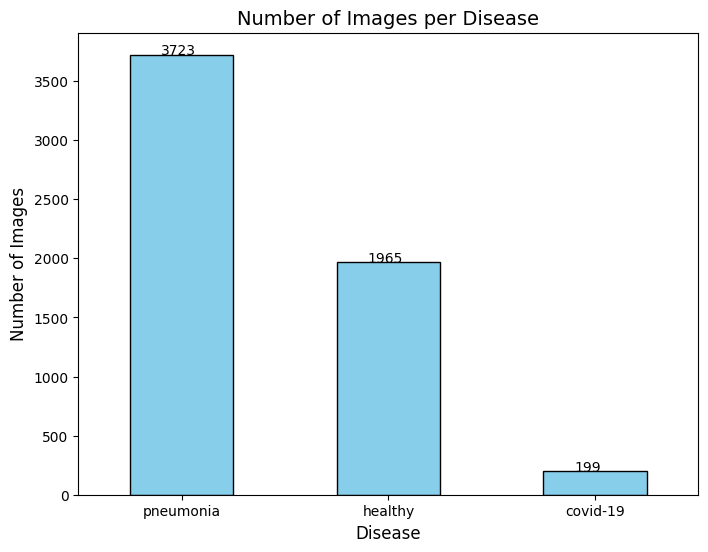

Training set size = 4709, Validation set size = 589, Test set size = 589


In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Path to the unzipped dataset in Google Colab
data_dir= "/content/covid-19_healthy"


# Initialize empty lists for storing image file paths and their corresponding labels
image_paths = []
labels = []

# Traverse the directory structure to populate image_paths and labels
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):  # Ensure it's a directory
        for file_name in os.listdir(label_dir):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
                image_paths.append(os.path.join(label_dir, file_name))
                labels.append(label)

# Create a Pandas DataFrame with the image file paths and labels
data_frame = pd.DataFrame({'image_paths': image_paths, 'labels': labels})

# Check if the DataFrame is empty
if data_frame.empty:
    print("Data frame is empty. Please check your data directory and file structure.")
else:
    # Visualize the number of images per class
    label_counts = data_frame['labels'].value_counts()
    ax = label_counts.plot(kind='bar', figsize=(8, 6), color='skyblue', edgecolor='black')

    plt.xlabel('Disease', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title('Number of Images per Disease', fontsize=14)
    plt.xticks(rotation=0, fontsize=10)

    # Annotate bar chart with counts
    for i in ax.patches:
        ax.text(i.get_x() + 0.15, i.get_height() + 0.5, str(i.get_height()), fontsize=10, color='black')

    plt.show()

    # Split the data into training (80%), validation (10%), and test sets (10%)
    strat = data_frame['labels']
    train_df, temp_df = train_test_split(data_frame, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    # Further split temp_df equally for validation and test sets (each 10%)
    strat_temp = temp_df['labels']
    valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat_temp)

    # Print the sizes of each split
    print(f"Training set size = {len(train_df)}, Validation set size = {len(valid_df)}, Test set size = {len(test_df)}")

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Determine the length of the test dataset
test_length = len(test_df)

# Find all factors of the test dataset length that are less than or equal to 80
factors = [n for n in range(1, test_length + 1) if test_length % n == 0 and test_length // n <= 80]

# Select the largest factor as the test batch size
test_batch_size = max(factors) if factors else test_length  # Default to test_length if no factors found

# Calculate the number of steps per epoch for the test dataset
test_steps = test_length // test_batch_size

# Define a function that returns the input image unchanged (identity function for no augmentation)
def identity(img):
    return img

# Create image data generators for the training, validation, and test datasets
train_augmentor = ImageDataGenerator(preprocessing_function=identity, horizontal_flip=True)
test_augmentor = ImageDataGenerator(preprocessing_function=identity)

# Flow from dataframe for training set
train_gen = train_augmentor.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',  # Since we have multiple classes (covid, healthy, pneumonia)
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

# Flow from dataframe for validation set
valid_gen = test_augmentor.flow_from_dataframe(
    dataframe=valid_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',  # Same as training (multi-class)
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

# Flow from dataframe for test set
test_gen = test_augmentor.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',  # Test set should also be multi-class
    color_mode='rgb',
    shuffle=False,  # No shuffling for test set to maintain order
    batch_size=test_batch_size
)

# Print the computed test steps for debugging
print(f"Test Steps per Epoch: {test_steps}")


Found 4709 validated image filenames belonging to 3 classes.
Found 589 validated image filenames belonging to 3 classes.
Found 589 validated image filenames belonging to 3 classes.
Test Steps per Epoch: 1


In [5]:
train_data = train_gen.class_indices
classes = list(train_data.keys())
images, labels = next(train_gen)
batch_size = len(labels)

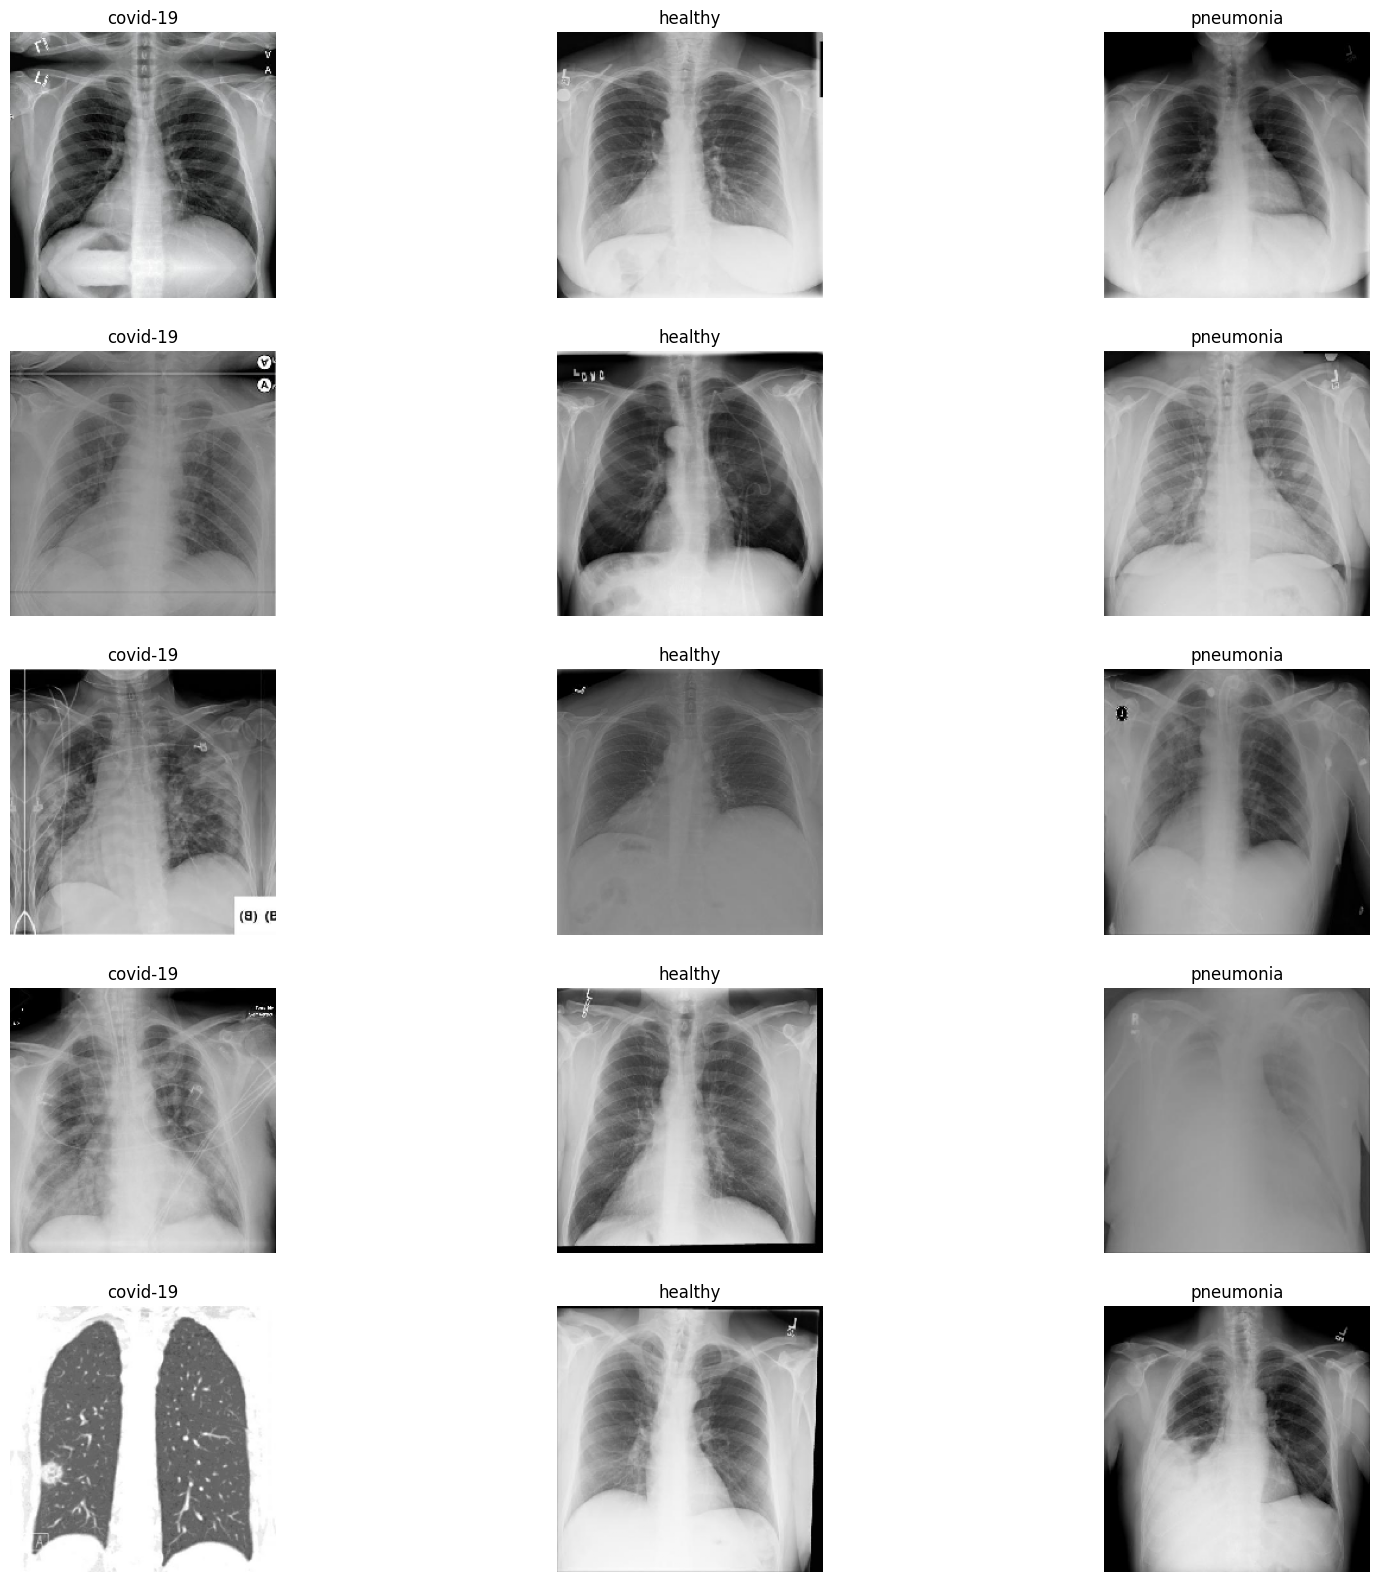

In [6]:

# Get class names and number of classes
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

# Create a dictionary to store images for each class
class_images = {class_name: [] for class_name in class_names}

# Loop over the samples until 5 images per class are found
while True:
    images, labels = next(train_gen)
    for j in range(len(labels)):
        class_name = class_names[np.argmax(labels[j])]
        if len(class_images[class_name]) < 5:
            class_images[class_name].append(images[j])

    # Stop once 5 images per class are found
    if all(len(images) == 5 for images in class_images.values()):
        break

# Create a figure with 5 rows and N columns
fig, axs = plt.subplots(5, num_classes, figsize=(20, 20))

# Loop over the classes and plot the corresponding images
for i in range(num_classes):
    for j in range(5):
        axs[j, i].imshow(class_images[class_names[i]][j]/255)
        axs[j, i].set_title(class_names[i])
        axs[j, i].axis('off')

plt.show()

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import DenseNet169

# Define input image size and channels
img_size = (224, 224)  # Adjust image size based on your dataset
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Determine the number of classes
class_count = len(train_gen.class_indices)  # Automatically detects number of classes

# Create the pre-trained model (DenseNet169 in this case)
base_model = DenseNet169(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Build the full model
model = Sequential([
    base_model,  # Add the pre-trained model
    Dense(class_count, activation='softmax')  # Output layer for multi-class classification
])

# Display model architecture
model.summary()


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)             │ (None, 1664)                │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           4,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,647,875 (48.25 MB)

 Trainable params: 12,489,475 (47.64 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adjust learning rate if necessary
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Updated file format as recommended
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_gen,
    epochs=20,  # You can adjust this value
    callbacks=[early_stop, model_checkpoint],  # Include both callbacks
    validation_data=valid_gen,
    verbose=1  # For progress logging
)


Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.6716 - loss: 1.5802
Epoch 1: val_loss improved from inf to 1.25422, saving model to best_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 504s 916ms/step - accuracy: 0.6717 - loss: 1.5788 - val_accuracy: 0.6503 - val_loss: 1.2542
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7575 - loss: 0.6644
Epoch 2: val_loss did not improve from 1.25422
295/295 ━━━━━━━━━━━━━━━━━━━━ 65s 218ms/step - accuracy: 0.7575 - loss: 0.6644 - val_accuracy: 0.0357 - val_loss: 12.0266
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7704 - loss: 0.6028
Epoch 3: val_loss did not improve from 1.25422
295/295 ━━━━━━━━━━━━━━━━━━━━ 65s 219ms/step - accuracy: 0.7704 - loss: 0.6026 - val_accuracy: 0.7114 - val_loss: 6.3167
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7778 - loss: 0.5916
Epoch 4: val_loss did not improve from 1.25422
295/295 ━━━━━━━━━━━━━━━━━━━━ 66s 222ms/step - accuracy: 0.7777 -

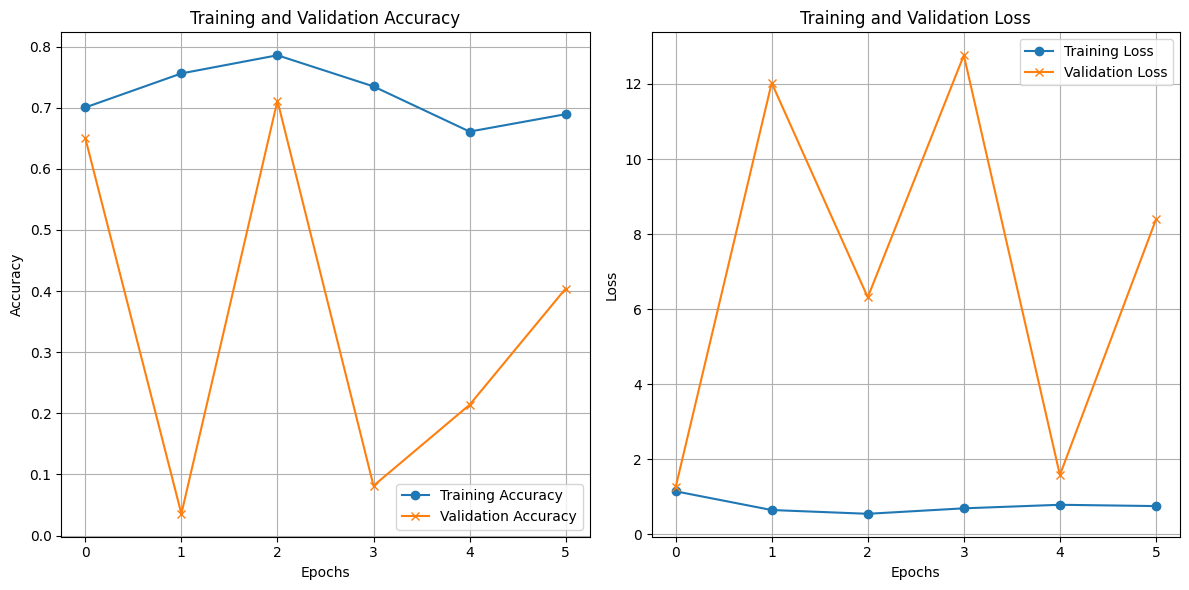

In [9]:
# Extract training and validation metrics from the history object
accuracy = history.history.get('accuracy', [])
val_accuracy = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

# Ensure epochs range matches the length of the metrics
epochs_range = range(len(accuracy))

# Set up the figure for plotting
plt.figure(figsize=(12, 6))

# Plot the training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


In [11]:
# Save the model in the recommended Keras format
model.save('DenseNet_Saved.keras')


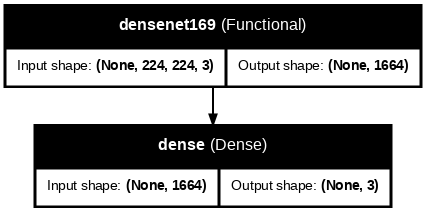

In [14]:
plot_model(
    model,
    to_file='DenseNet_Model_Simple.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,  # Disable nested expansion
    dpi=72               # Lower resolution
)


37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 372ms/step


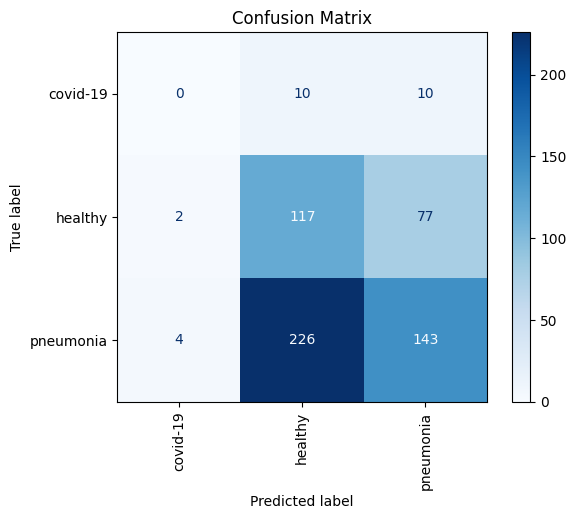

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for the validation/test dataset
y_pred = model.predict(valid_gen)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
y_true = valid_gen.classes  # True class labels from the validation generator

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_labels = list(valid_gen.class_indices.keys())  # Class names

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adjust learning rate if necessary
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Save in native Keras format
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,  # Save the model only if validation accuracy improves
    verbose=1  # Enable logging for model checkpointing
)

# Train the model
history = model.fit(
    train_gen,
    epochs=20,  # Set desired number of epochs
    callbacks=[model_checkpoint],  # Include only the ModelCheckpoint callback
    validation_data=valid_gen,
    verbose=1  # Display progress logs during training
)


Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.6671 - loss: 0.9560
Epoch 1: val_accuracy improved from -inf to 0.63328, saving model to best_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 402s 714ms/step - accuracy: 0.6671 - loss: 0.9556 - val_accuracy: 0.6333 - val_loss: 8.2926
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6494 - loss: 0.8467
Epoch 2: val_accuracy did not improve from 0.63328
295/295 ━━━━━━━━━━━━━━━━━━━━ 124s 218ms/step - accuracy: 0.6494 - loss: 0.8467 - val_accuracy: 0.6333 - val_loss: 0.8283
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6355 - loss: 0.8344
Epoch 3: val_accuracy improved from 0.63328 to 0.64177, saving model to best_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 67s 228ms/step - accuracy: 0.6355 - loss: 0.8343 - val_accuracy: 0.6418 - val_loss: 2.2771
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6752 - loss: 0.7212
Epoch 4: val_accuracy did not improve from 0.64177
295/295 ━

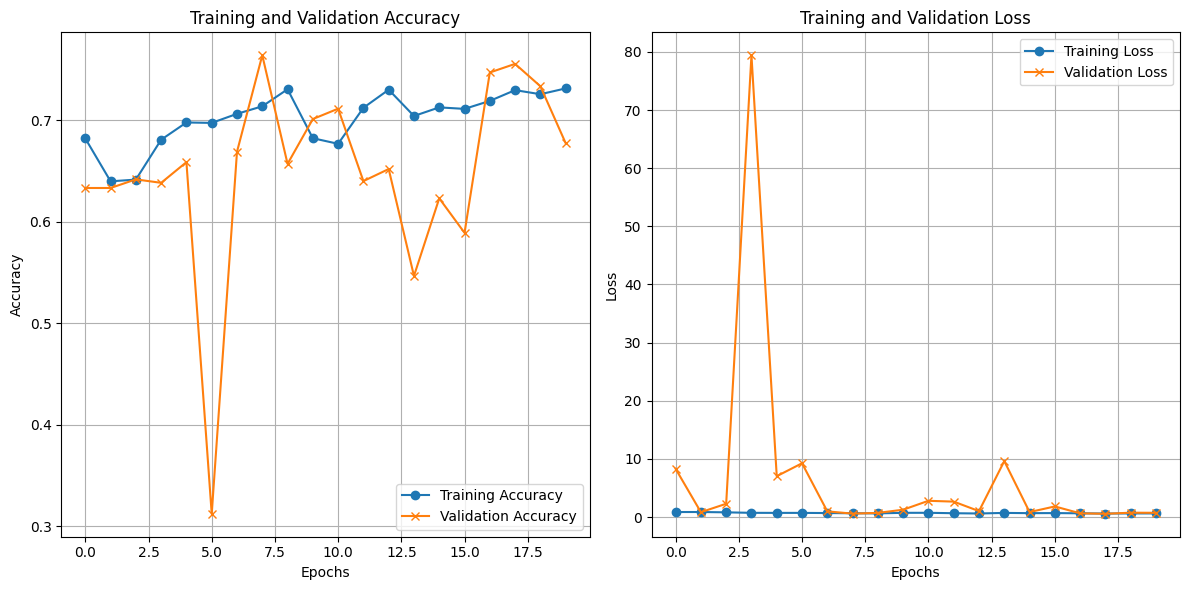

In [17]:
# Extract training and validation metrics from the history object
accuracy = history.history.get('accuracy', [])
val_accuracy = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

# Ensure epochs range matches the length of the metrics
epochs_range = range(len(accuracy))

# Set up the figure for plotting
plt.figure(figsize=(12, 6))

# Plot the training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 323ms/step


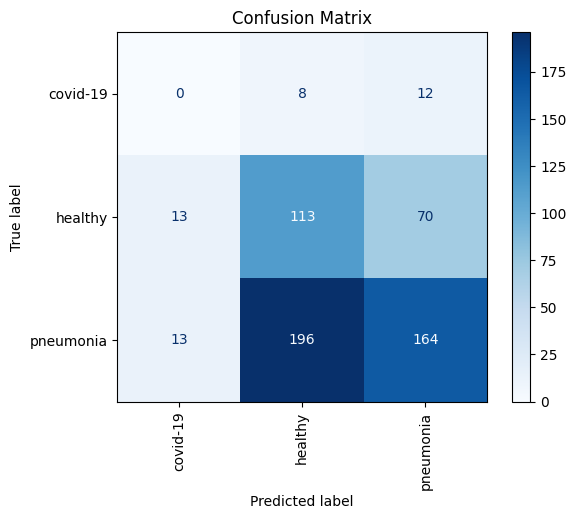

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for the validation/test dataset
y_pred = model.predict(valid_gen)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
y_true = valid_gen.classes  # True class labels from the validation generator

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_labels = list(valid_gen.class_indices.keys())  # Class names

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()
